# MACD in Python / Pandas

MACD(a, b, c) where:

a: is short moving average
b: is a longer moving average

Calculate the difference of a and b

Calculate the c-interval moving average

Common parameters are MACD(12,26,9)

For more background see: [MACD on Wikipedia](https://en.m.wikipedia.org/wiki/MACD)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from getstock import *

# set figsize...
plt.rcParams["figure.figsize"] = [16,16]

In [20]:
raw_data = getDailyStockPrices('XOM')

In [21]:
stock_data = raw_data['2019-12-01':'2020-03-03']

In [22]:
# calculate EMAs

# 26 day
ema_26 = stock_data['close'].ewm(span=26).mean()

# 12 day
ema_12 = stock_data['close'].ewm(span=12).mean()

# difference between fast and slow averages
macd = ema_12 - ema_26

# calculate the 9 period EMA of the macd
macd_9_ema = macd.ewm(span=9).mean()

# calculate the difference the macd and the "signal line"
macd_diff = macd - macd_9_ema

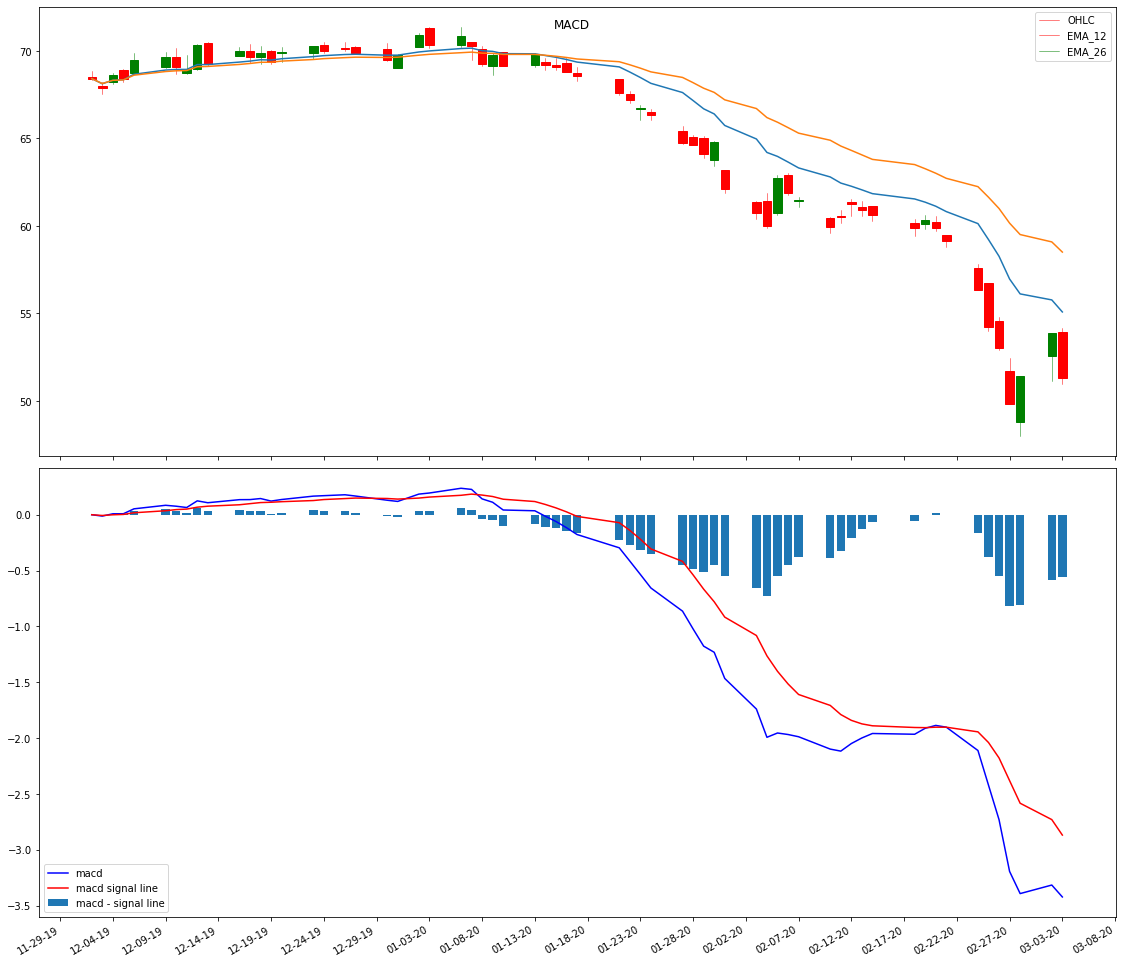

In [23]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from mpl_finance import candlestick_ohlc

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize = (16, 16))

# plot_day_summary(ax, quotes, ticksize=3)
candlestick_ohlc(ax1, zip(dates.date2num(stock_data.index.to_pydatetime()),
                         stock_data['open'], stock_data['high'],
                         stock_data['low'], stock_data['close']),
                         width=0.8, colorup='g', colordown='r')

#ax1.plot(stock_data['close'])
ax1.plot(ema_12)
ax1.plot(ema_26)
ax1.legend(['OHLC', 'EMA_12', 'EMA_26'])

ax2.plot(macd, "b-")
ax2.plot(macd_9_ema, "r-")
ax2.bar(macd.index, macd_diff)
ax2.legend(['macd', 'macd signal line', 'macd - signal line'])

ax2.xaxis.set_major_locator(dates.DayLocator(interval=5))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%m-%d-%y'))

fig.tight_layout()
fig.autofmt_xdate()
fig.suptitle("MACD")
plt.show()

## Now let's try to do make a trading strategy from this

In [24]:
# given macd_diff, can we turn that into a series of signals?
macd_diff.head()

timestamp
2019-12-02    0.000000
2019-12-03   -0.005385
2019-12-04    0.008953
2019-12-05    0.006236
2019-12-06    0.035182
Name: close, dtype: float64

In [25]:
def calc_signal(x):
    if x > 0:
        return 1 # buy
    elif x < 0:
        return -1 # sell
    else:
        return 0

In [26]:
signal = macd_diff.apply(calc_signal)

In [27]:
signal

timestamp
2019-12-02    0
2019-12-03   -1
2019-12-04    1
2019-12-05    1
2019-12-06    1
             ..
2020-02-26   -1
2020-02-27   -1
2020-02-28   -1
2020-03-02   -1
2020-03-03   -1
Name: close, Length: 63, dtype: int64

In [ ]:
# now let's accumulate some P&L
position = 0
trade_size = 1 # 1 share
pnl = 0
previous_signal = 0
start_price = 0

for index, row in stock_data.iterrows():
    current_signal = signal.loc[index]
    if current_signal != previous_signal: # we need to do a trade
        # first check if we have an open position
        if position != 0: 
            # first we need to close the position and calculate P&L
            current_pnl = position * (row['open'] - start_price)
            pnl += current_pnl
            msg = "{0} Closing. signal: {1:d} current_price: {2:.2f} start_price: {3:.2f} pnl: {4:.2f}".format(index, current_signal, row['open'], start_price, current_pnl)
            print(msg)
            
        # now open a new position
        position = trade_size * current_signal # buy if signal is positive, sell if signal is negative
        start_price = row['open']
        msg = "{0} Opening. signal: {1:d} current_price: {2:.2f}".format(index, current_signal, row['open'])
        print(msg)    
        previous_signal = current_signal

print("Final P&L: {0:.2f}".format(pnl))